## Check Test Dataset prediction results

In [1]:
import numpy as np

Y_pred_dir = "/Users/achs/PhD/code/CT-MRI_LandmarkDetection/Spartan/trained_models/divided_dataset/straight_model/mean_two_landmarks/"

Y_test_pred_file = "bestVal_straight_model_divided_176_88_48_mean_two_landmarks_MTL_p.npy"
Y_test_file = "bestVal_straight_model_divided_176_88_48_mean_two_landmarks_MTL.npy"
# test_y_pred_file = "bestVal_first_model_y_test.npy"

Y_test_pred_path = Y_pred_dir + Y_test_pred_file
Y_test_pred = np.load(Y_test_pred_path)

Y_test_path = Y_pred_dir + Y_test_file
Y_test_read = np.load(Y_test_path)

In [2]:
import tensorflow as tf

import Spartan.support_modules as supporter
import Functions.MyDataset as MyDataset

# Get the Test Dataset Prediction Results
datasets_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/Rescaled/"
size = (176, 176, 48)
with_res = True

str_size = str(size[0]) + "_" + str(size[1]) + "_" + str(size[2])
if with_res:
    str_size = str_size + "_PD"

dataset_path = datasets_dir + str_size + "/"
pat_splits = MyDataset.get_pat_splits(static=True)
X_test, Y_test, res_test = \
    supporter.load_dataset(dataset_path, size, pat_splits, with_res=with_res, only_test=True)

# Because the resolution is for 4 landmark points, so we repeat it to make the calculation easier.
res_test_R2 = np.repeat(res_test, 2, axis=1)
res_test_R2 = res_test_R2.reshape(400, 1, 3)

X_test Shape:  (200, 176, 176, 48)
Y_test Shape:  (200, 4, 3)
X_test_reshape Shape:  (200, 176, 176, 48, 1)
Y_test Shape:  (200, 4, 3)


In [3]:
# Y_test_mapped = Y_test * res_test_R4 / 0.15
# Y_MTL_test_mapped = np.mean(Y_test_mapped.reshape((400, 2, 3)), axis=1).reshape((400, 1, 3))
Y_MTL_test = np.mean(Y_test.reshape((400, 2, 3)), axis=1).reshape((400, 1, 3))

print("Y_MTL_test Shape: ", Y_MTL_test.shape)

Y_MTL_test Shape:  (400, 1, 3)


## Check the difference between Predictions and Ground Truth

In [4]:
Y_test_centre_pred_org = Y_test_pred * res_test_R2 / 0.15
np.save("/Volumes/Shawn_HDD/PhD/Project/Date/bestVal_straight_model_divided_176_88_48_mean_two_landmarks_MTL_pred_org", Y_test_centre_pred_org)

### Ground Truth points and Prediction points distance

In [5]:
# 1. Total error distance
# 2. Maximum one point's error distance
# 3. If it can involve the Ground Truth points
# 4. If it can involve the Target Area

# 1. Total error distance
err_diff = (Y_MTL_test - Y_test_pred) * res_test_R2
square_err_diff = tf.pow(err_diff, 2)
sum_square_err_diff = tf.reduce_sum(square_err_diff, axis=[1, 2])

2023-05-09 15:54:22.863634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
min_err_idx = np.argmin(sum_square_err_diff, axis=0)
max_err_idx = np.argmax(sum_square_err_diff, axis=0)
print(f"Min[{min_err_idx}]: {sum_square_err_diff[min_err_idx]}")
print(f"Max[{max_err_idx}]: {sum_square_err_diff[max_err_idx]}")
print(f"Mean: {np.mean(sum_square_err_diff)}")

Min[104]: 0.1841956377029419
Max[161]: 8.146464347839355
Mean: 2.1486549377441406


In [7]:
print(Y_MTL_test[161])
print(Y_test_pred[161])

[[ 53.258404 100.32405   26.91925 ]]
[[ 50.53746  100.470116  26.927181]]


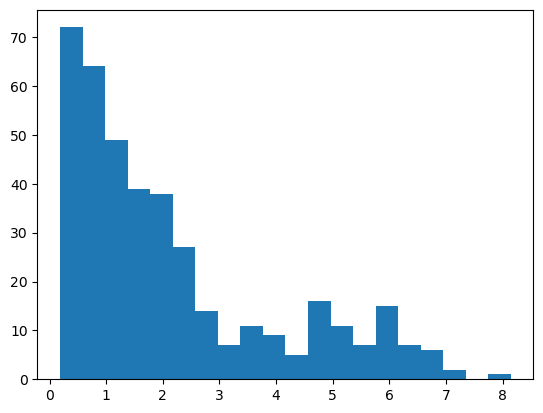

In [8]:
import matplotlib.pyplot as plt
import numpy as np

mu = np.mean(sum_square_err_diff)
sigma = np.std(sum_square_err_diff)

# Create the bins and histogram
count, bins, ignored = plt.hist(sum_square_err_diff, 20)

plt.show()

In [9]:
idx = max_err_idx

pat_names = MyDataset.get_pat_names()
test_pat_idx = MyDataset.get_pat_splits(static=True)[2] # 0: train, 1: val, 2: test

test_pt_idx = np.floor(idx / 100).astype(int)
pt_aug_id = np.floor(idx % 100 / 2).astype(int) + 1

pat_name = pat_names[test_pat_idx[test_pt_idx]]

print(f"Patient {pat_name}, Aug Id: {pt_aug_id}")

Patient GE, Aug Id: 31


In [10]:
## Check the cropped results
import numpy as np
import Functions.MyDataset as MyDataset
import Functions.Visualization as Visualization

import importlib

importlib.reload(Visualization)

aug_dir = "/Volumes/Shawn_HDD/PhD/Project/Date/augmentation_from_matlab/original_augmentation_data/"
pt_aug_path = aug_dir + pat_name + "_aug_" + str(pt_aug_id) + ".mat"

pixel_space = [0.15, 0.15, 0.15]

pt_aug_volume, pt_aug_pts, _ = MyDataset.load_mat_data(pt_aug_path)

# # Ground Truth
#
# Visualization.show_two_centres(pt_aug_volume, pt_left_centre, pt_right_centre, pixel_space)
# # Prediction on original volumes
# Visualization.show_two_centres(pt_aug_volume, , , pixel_space)

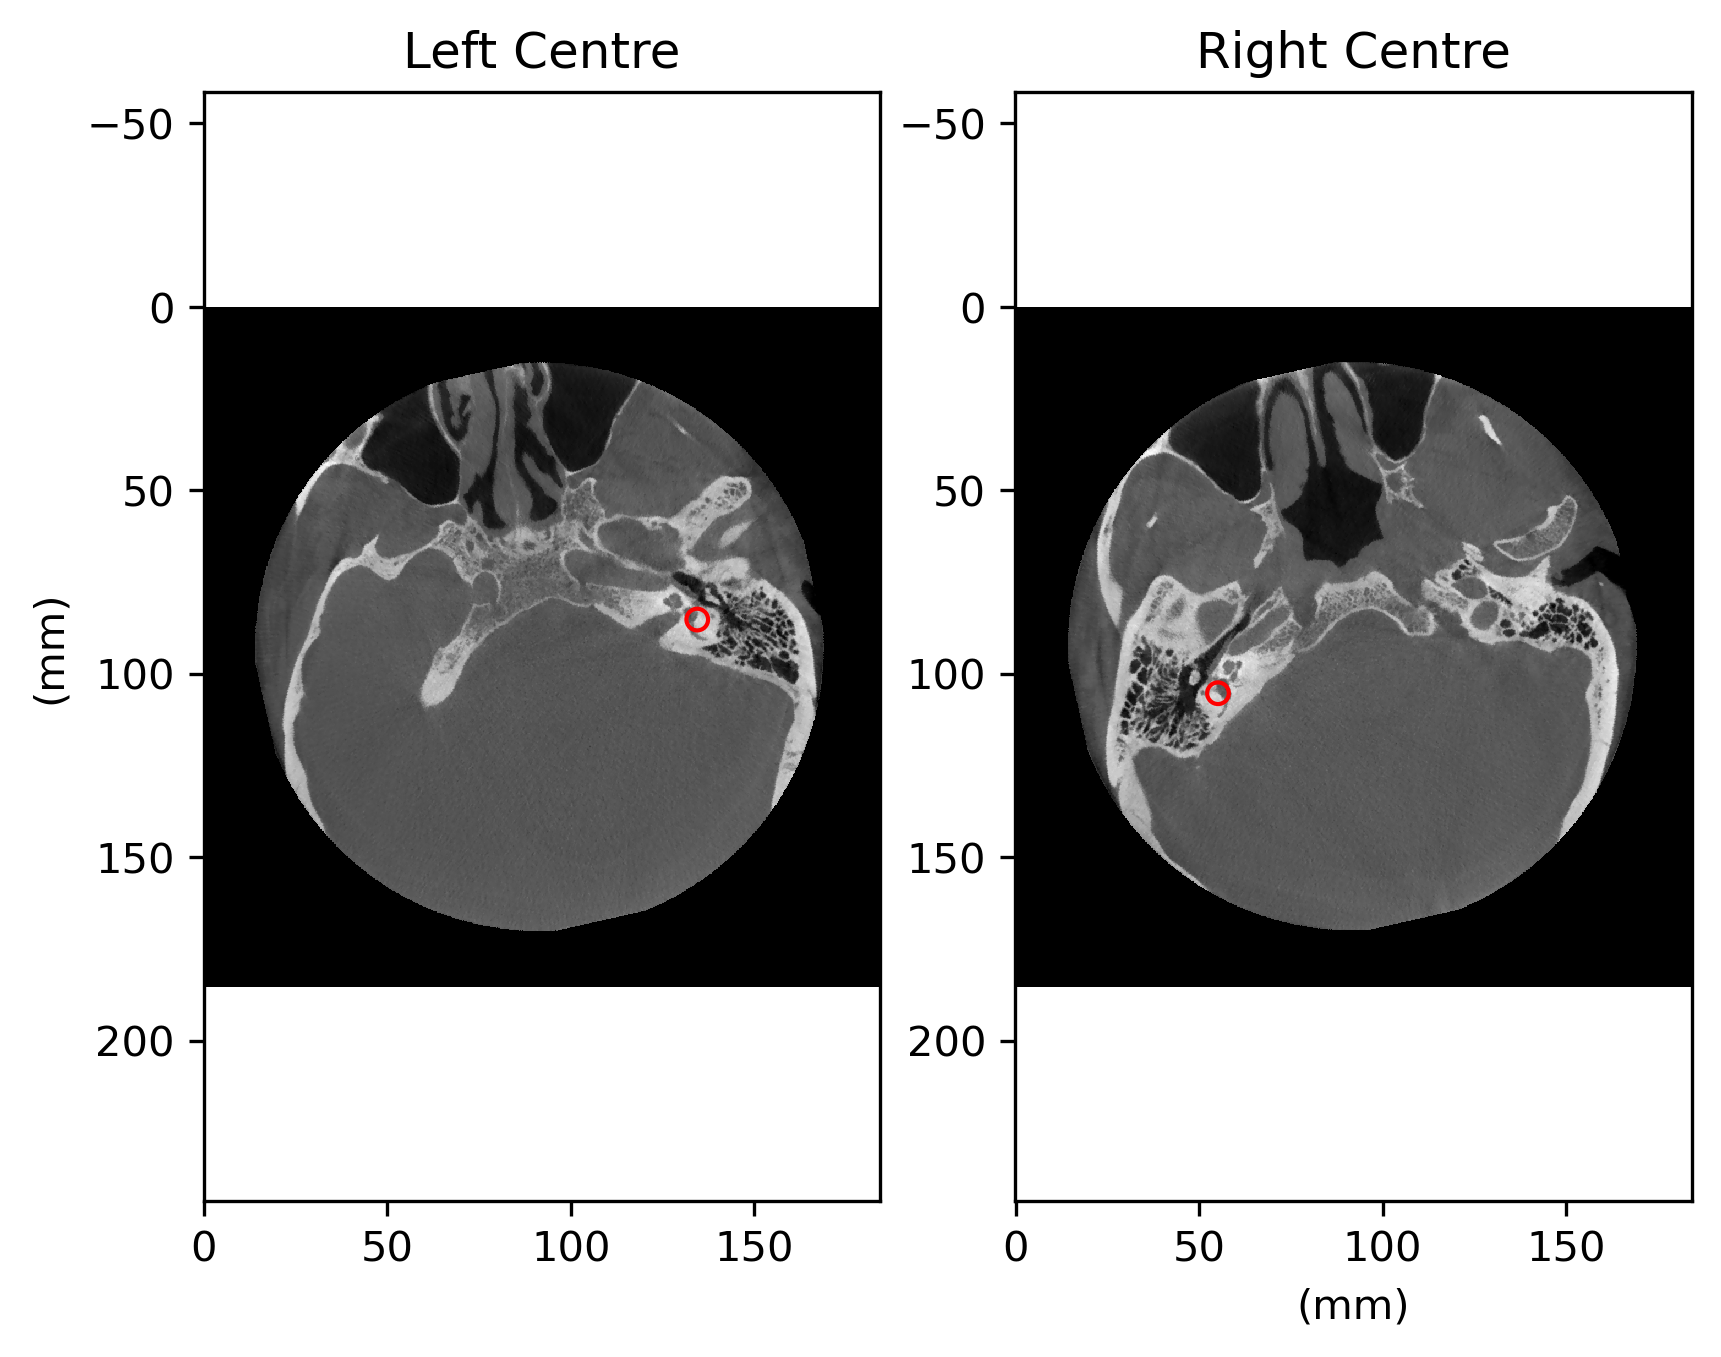

In [11]:
importlib.reload(Visualization)

# Ground Truth
centres = np.mean(pt_aug_pts.reshape((2,2,3)), axis=1)

Visualization.show_two_centres(pt_aug_volume, centres, pixel_space)

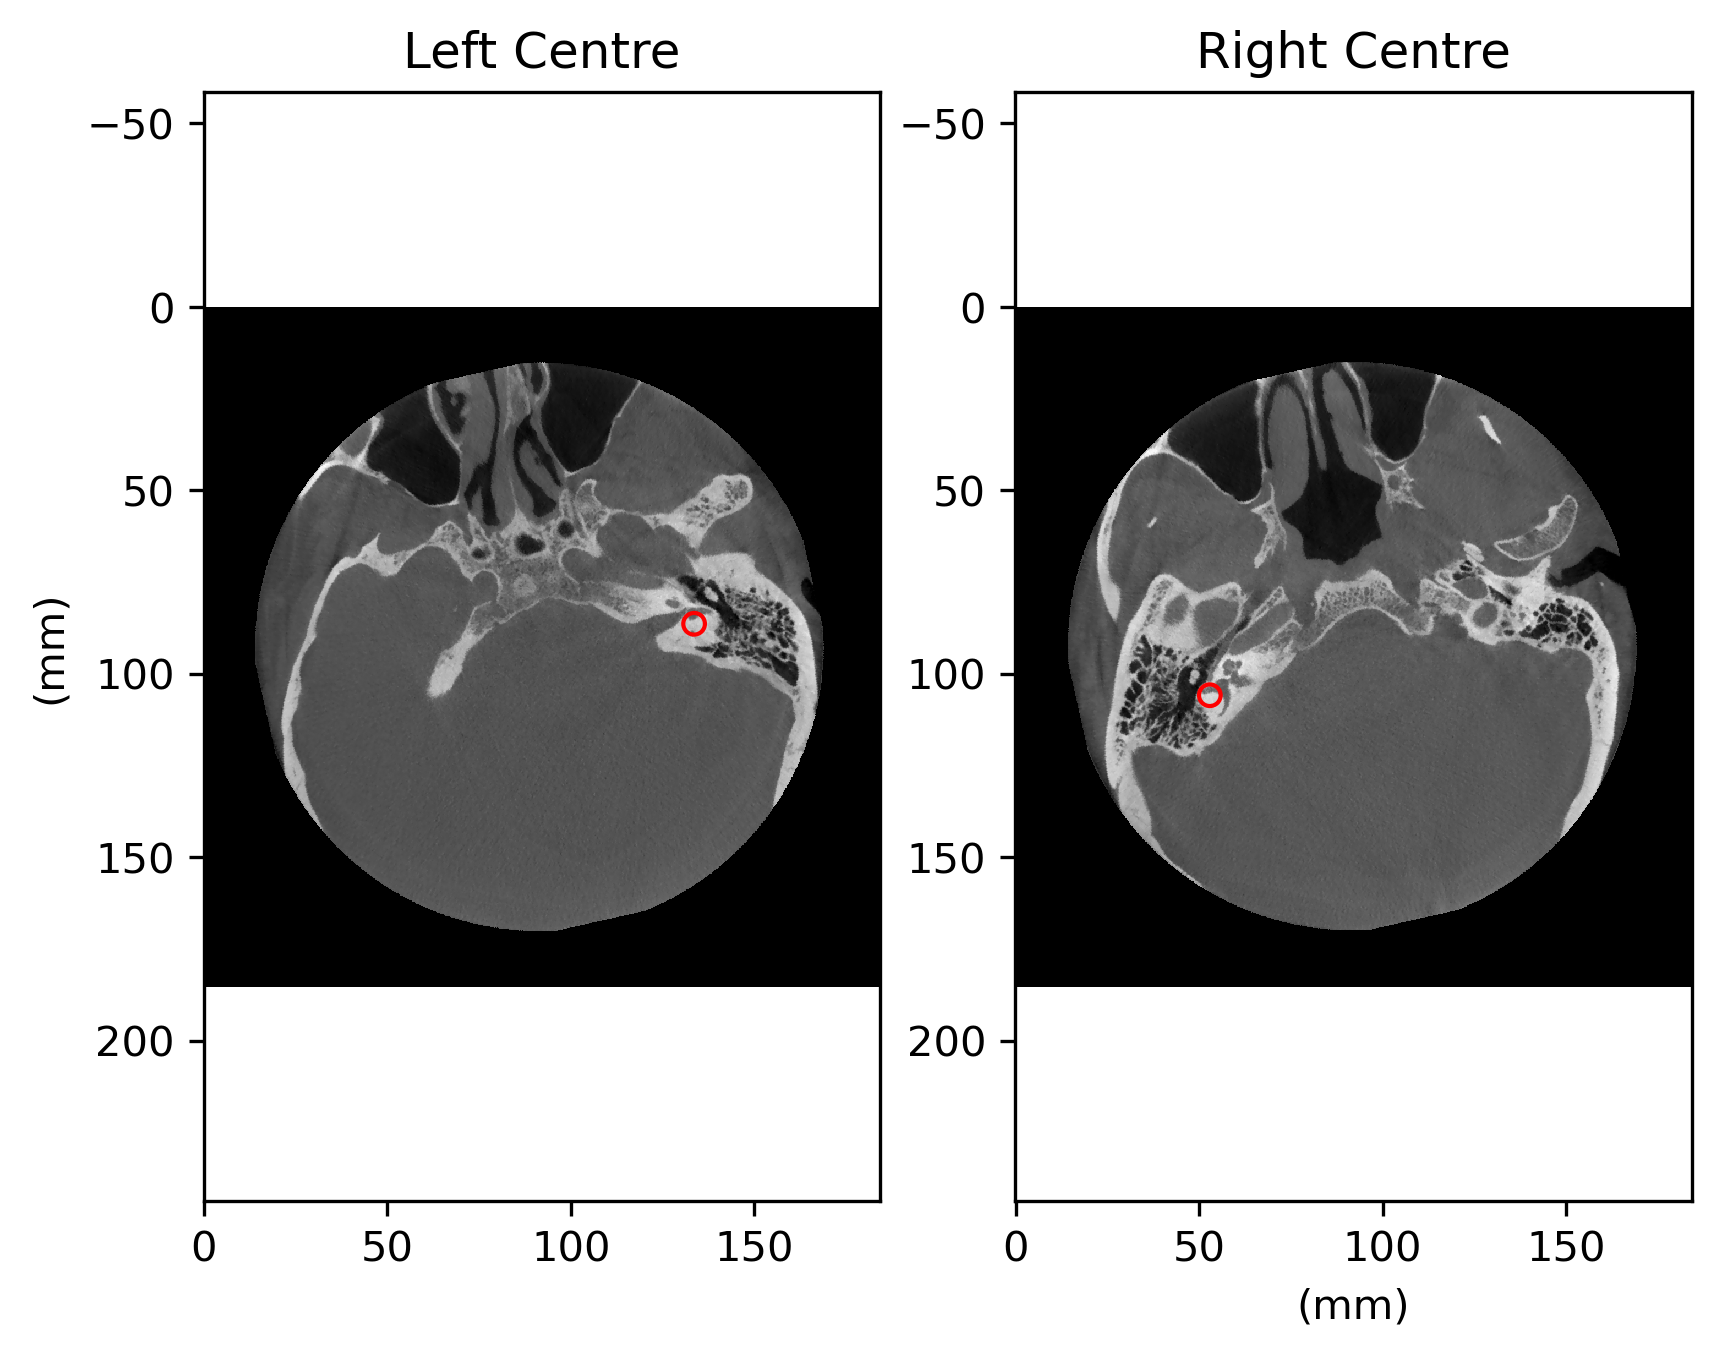

In [12]:
# Prediction on original volumes
Y_test_pred_org = Y_test_pred * res_test_R2 / 0.15
Visualization.show_two_centres(pt_aug_volume, np.squeeze(Y_test_pred_org[[160,161]]), pixel_space)

### Ground Truth points to the Cropped Volume's border distance

In [13]:
import Functions.MyCrop as MyCrop

anchor = centres[1]
anchor_pred = Y_test_pred_org[idx, 0]

crop_s = ((45, 45), (45, 45), (45, 45))
d = MyCrop.distance_from_border(pt_aug_volume.shape, pt_aug_pts[2:4], anchor, crop_size=crop_s)
d_pred = MyCrop.distance_from_border(pt_aug_volume.shape, pt_aug_pts[2:4], anchor_pred, crop_size=crop_s)

# attention: this is (row, column, slice) same as (y, x, z)
print("Based on Ground Truth: ", d)
print("Based on Prediction: ", d_pred)

Based on Ground Truth:  [[[33.68221363 35.64741729 49.83332209]
  [56.31778637 54.35258271 40.16667791]]

 [[54.31778637 52.35258271 38.16667791]
  [35.68221363 37.64741729 51.83332209]]]
Based on Prediction:  [[[48.48614623 32.01720645 46.48756306]
  [41.51385377 57.98279355 43.51243694]]

 [[69.12171897 48.72237186 34.82091889]
  [20.87828103 41.27762814 55.17908111]]]


In [ ]:
# show ground truth cropped volume
importlib.reload(Visualization)

left_area, left_landmarks, left_cropped_length, \
    right_area, right_landmarks, right_cropped_length = MyCrop.crop_volume(pt_aug_volume, pt_aug_pts)

left_centre = np.mean(left_landmarks, axis=0).reshape(1,3)
right_centre = np.mean(right_landmarks, axis=0).reshape(1,3)
centres_cropped = np.concatenate((left_centre, right_centre), axis=0)
Visualization.show_two_centres_cropped(left_area, right_area, centres_cropped, pixel_space)

In [ ]:
# for convenient...
centres_pred_r2 = np.repeat(Y_test_pred_org[[160, 161]], 2, axis=1).reshape(4,3)
print(centres_pred_r2.shape)
print(centres_pred_r2)

In [ ]:
# show prediction cropped volume
left_area_pred, left_landmarks_pred, left_cropped_length_pred, \
    right_area_pred, right_landmarks_pred, right_cropped_length_pred \
    = MyCrop.crop_volume(pt_aug_volume, centres_pred_r2)

left_centre_pred = np.mean(left_landmarks_pred, axis=0).reshape(1,3)
right_centre_pred = np.mean(right_landmarks_pred, axis=0).reshape(1,3)
centres_cropped_pred = np.concatenate((left_centre_pred, right_centre_pred), axis=0)
Visualization.show_two_centres_cropped(left_area_pred, right_area_pred, centres_cropped_pred, pixel_space)